In [4]:
import os
import requests
import pandas as pd
from pyspark.sql import SparkSession
from tmlt.analytics.privacy_budget import PureDPBudget, RhoZCDPBudget
from tmlt.analytics.query_builder import QueryBuilder
from tmlt.analytics.session import Session
from pyspark.sql.functions import desc, asc

In [5]:
from tmlt.core.transformations.spark_transformations.filter import Filter
from tmlt.core.transformations.spark_transformations.agg import Count
from tmlt.core.domains.spark_domains import convert_spark_schema, SparkDataFrameDomain
from tmlt.core.metrics import SymmetricDifference
from tmlt.core.measurements.noise_mechanisms import AddGeometricNoise
from tmlt.core.utils.misc import print_sdf

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from tmlt.analytics.keyset import KeySet

In [8]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
spark = SparkSession.builder.getOrCreate()

22/07/13 12:41:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/13 12:41:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [26]:
# """
# |-----|-----|-------------|------------------------|----------------------------|----------------------------|
# |SSIC | UEN | staff_count | innovation_expenditure | intramural_r&d_expenditure | extramural_r&d_expenditure |
# |-------------------------------------------------------------------------------------------------------------
# | S0  |  1  |   234       |    23000.508          |       3050.231               |   56000.000              |
# | S1  |  2  |   234       |    23000.508          |       3050.231                |   56000.000              |
# | S0  |  3  |   234       |    23000.508          |       250.231                |   56000.000              |
# | S2  |  4  |   234       |    23000.508          |       650.231                |   56000.000              |
# | S3  |  5  |   234       |    23000.508          |       3050.231                |   56000.000              |
# | S2  |  6  |   234       |    23000.508          |       3050.231                |   56000.000              |
# |-------------------------------------------------------------------------------------------------------------

# Types:
# SSIC: string 
# UEN: integer (unique values generated using counter)
# innovation_expenditure: float (default to 3 decimal places)
# intramural_r&d_expenditure: float (default to 3 decimal places)
# extramural_r&d_expenditure: float (default to 3 decimal places)
# """

# def create_simulated_data(no_of_records=40, no_of_sectors=5, decimal_points=3):
#     simulated_data = pd.DataFrame()     
    
#     # setting sectors name as S1 ..... S[no_of_sectors]
#     SSIC = ["S" + str(sector_no) for sector_no in range(1, no_of_sectors + 1)]
#     simulated_data["SSIC"] = np.random.choice(SSIC, size=no_of_records) 
    
#     # no of records == no of uniques UENs(firms)
#     simulated_data["UEN"] = list(range(1, no_of_records + 1))                                                                                                                                         
    
#     # using gamma distribution 
#     # https://en.wikipedia.org/wiki/Gamma_distribution
#     simulated_data["staff_count"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
    
#     simulated_data["innovation_expenditure"] = np.round(np.random.gamma(10, 300, size=no_of_records), decimal_points) 
#     simulated_data["intramural_r&d_expenditure"] = np.round(np.random.gamma(10, 300, size=no_of_records), decimal_points) 
#     simulated_data["extramural_r&d_expenditure"] = np.round(np.random.gamma(10, 300, size=no_of_records), decimal_points) 
    
#     return simulated_data


# def save_data(data, filename="simulated_data.csv"):
#     data.to_csv(filename, mode='w', index=False)


In [11]:
"""
|-----|-----|-------------|------------------------|----------------------------|----------------------------|
|SSIC | UEN | staff_count | innovation_expenditure | intramural_r&d_expenditure | extramural_r&d_expenditure |
|-------------------------------------------------------------------------------------------------------------
| S0  |  1  |   234       |    23000.508          |       3050.231               |   56000.000              |
| S1  |  2  |   234       |    23000.508          |       3050.231                |   56000.000              |
| S0  |  3  |   234       |    23000.508          |       250.231                |   56000.000              |
| S2  |  4  |   234       |    23000.508          |       650.231                |   56000.000              |
| S3  |  5  |   234       |    23000.508          |       3050.231                |   56000.000              |
| S2  |  6  |   234       |    23000.508          |       3050.231                |   56000.000              |
|-------------------------------------------------------------------------------------------------------------

Types:
SSIC: string 
UEN: integer (unique values generated using counter)
innovation_expenditure: float (default to 3 decimal places)
intramural_r&d_expenditure: float (default to 3 decimal places)
extramural_r&d_expenditure: float (default to 3 decimal places)
"""

# excluding "Foreign Firm" for now 
FIRM_TYPES = ["LLC", "MNC", "SME"] 

#Government", "Private Sector Company", "Institute of Higher Learning", "Public Research Institute"
OWNERSHIP_TYPES = ["Gov", "IHL", "Public RI", "Private"]

FIRM_PUBLIC_PRIVATE = {
    "public": OWNERSHIP_TYPES[:3],
    "private": OWNERSHIP_TYPES[-1]
}

NATIONALITY_TYPES = ["SC", "PR", "FC"]

QUALIFICATION_TYPES = ["PhD", "Masters", "Bachelors", "Non-degree", "Post-grad"]


def create_simulated_data(no_of_records=14, no_of_sectors=3, decimal_points=3):
    simulated_data = pd.DataFrame()     
    
    # setting sectors name as S1 ..... S[no_of_sectors]
    SSIC = ["S" + str(sector_no) for sector_no in range(1, no_of_sectors + 1)]
    simulated_data["SSIC"] = np.random.choice(SSIC, size=no_of_records) 
    
    # no of records == no of uniques UENs(firms)
    simulated_data["UEN"] = list(range(1, no_of_records + 1))                                                                                                                                         
    
    # firm type 
    simulated_data["firm_type"] = np.random.choice(FIRM_TYPES, size=no_of_records) 
    
    #ownership type
    simulated_data["ownership_type"] = np.random.choice(OWNERSHIP_TYPES, size=no_of_records)
    
    # berd
    simulated_data["exp_total_rnd"] = np.round(np.random.gamma(10, 300, size=no_of_records), decimal_points) 
    
    # using gamma distribution 
    # https://en.wikipedia.org/wiki/Gamma_distribution
    simulated_data["no_sc_researchers"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
    simulated_data["no_pr_researchers"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
    simulated_data["no_fc_researchers"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
    
    simulated_data["no_phd_researchers"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
    simulated_data["no_masters_researchers"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
    simulated_data["no_bachelors_researchers"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
    simulated_data["no_nondegree_researchers"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
    simulated_data["no_postgrad_researchers"] = np.random.gamma(2, 150, size=no_of_records).astype(int)
     
    return simulated_data


def save_data(data, filename="simulated_limited_data.csv"):
    data.to_csv(filename, mode='w', index=False)

In [13]:
spark = (
    SparkSession.builder
    .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")
    .config("spark.executor.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")
    .getOrCreate()
)

In [28]:
simulated_data = create_simulated_data()
save_data(simulated_data)

public_data = spark.read.csv("simulated_limited_data.csv", header=True, inferSchema=True)
public_data.count()
public_data.groupby(public_data.SSIC).count().show()

+----+-----+
|SSIC|count|
+----+-----+
|  S3|    4|
|  S2|    5|
|  S1|    5|
+----+-----+



In [15]:
# check the distribution
# public_data.toPandas().no_postgrad_researchers.hist();
# public_data.toPandas().exp_total_rnd.hist();
# public_data.toPandas().no_masters_researchers.hist();

In [29]:
public_data.show()

+----+---+---------+--------------+-------------+-----------------+-----------------+-----------------+------------------+----------------------+------------------------+------------------------+-----------------------+
|SSIC|UEN|firm_type|ownership_type|exp_total_rnd|no_sc_researchers|no_pr_researchers|no_fc_researchers|no_phd_researchers|no_masters_researchers|no_bachelors_researchers|no_nondegree_researchers|no_postgrad_researchers|
+----+---+---------+--------------+-------------+-----------------+-----------------+-----------------+------------------+----------------------+------------------------+------------------------+-----------------------+
|  S1|  1|      MNC|       Private|     1425.392|              212|               11|              223|               321|                   425|                     200|                     606|                    398|
|  S3|  2|      SME|       Private|     2910.566|              371|              408|              296|               35

In [30]:
from scipy.stats import laplace

def print_laplace_confidence_interval(sensitivity, epsilon, confidence_score=0.99):
    # formula is noise_scale = stability/epsilon
    noise_scale_exact = sensitivity/epsilon
    noise_scale_float = float(noise_scale_exact)

    # https://en.wikipedia.org/wiki/Laplace_distribution
    noise_rvs = laplace(loc=0, scale=noise_scale_float) # b value for Laplace distribution

    # print(noise_rvs)
    # print(f"sensitivity: {sensitivity}")
    # # print(sum_privacy_budget)
    print(f"noise scale: {noise_scale_float}")
    print(f"variance: {noise_rvs.var()}")

    #interval(alpha, loc=0, scale=1)
    print(f"confidence interval: {noise_rvs.interval(confidence_score)}") 
    

In [31]:
def visualise(perturbed_df, true_df, attributes, query_type, y_label="", title="", sum_over=None, filter_by=None): 
    """
        attributes: 
        query_type: {count, sum}
        y_label:
        title: 
        sum_over: for summation query 
        filter_by: 
    """

    if query_type == "count":
        pd_perturbed = perturbed_df.toPandas().rename(columns={query_type: 'noisy_' + query_type}).sort_values("SSIC")
        
        pd_true = true_df
        if filter_by == OWNERSHIP_TYPES[-1]:
            pd_true = pd_true.filter(true_df.ownership_type == OWNERSHIP_TYPES[-1])
        
        pd_true = pd_true.groupBy(["SSIC"] + attributes).count().toPandas().rename(columns={'count': 'true_' + query_type}).sort_values("SSIC")  
            
    else:
        name = '{}_sum'.format(sum_over)
        pd_perturbed = perturbed_df.toPandas().rename(columns={name: 'noisy_' + query_type}).sort_values("SSIC")
        name = 'sum({})'.format(sum_over)
        pd_true = true_df.groupBy(['SSIC'] + attributes).sum(sum_over).toPandas().rename(columns={name: 'true_' + query_type}).sort_values("SSIC") #.sort(asc(auto_org_name))
    
    true_perturbed = pd.merge(pd_true, pd_perturbed, on=['SSIC'] + attributes, how='inner')
    
    if query_type == "count": 
        true_perturbed['error'] = true_perturbed['noisy_count'] - true_perturbed['true_count']
    else:
        true_perturbed['error'] = true_perturbed['noisy_sum'] - true_perturbed['true_sum']
    
    x_labels = ["{}-{}".format(ssic, attr_val) for ssic, attr_val, in zip(true_perturbed['SSIC'], true_perturbed[attributes[0]])]
    
    print(true_perturbed.sort_values("SSIC"))
    # error = perc_error(results['True'], results['Geom-DP-'+str(epsilon)])
    
    ax = true_perturbed.plot.bar(rot=45, figsize=(8, 5), width=0.8, fontsize=12, colormap = 'Accent')
    plt.title(title, fontsize=16)
    plt.xticks(np.arange(len(true_perturbed)), x_labels, rotation=45)    
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel(y_label, fontsize = 14)
    # plt.ylim(-50)
    # plt.legend(fontsize = 12, labels=labels)
    return plt 

## Querying -- Sectoral Analysis

In [32]:
print("Number of firms in each sector")
public_data.groupby(public_data.SSIC).count().show()

Number of firms in each sector
+----+-----+
|SSIC|count|
+----+-----+
|  S3|    4|
|  S2|    5|
|  S1|    5|
+----+-----+



In [33]:
session = Session.from_dataframe(
    privacy_budget=PureDPBudget(float('inf')),
    source_id="sectors_analysis",
    dataframe=public_data
)

### 1. Number of R&D firms by Enterprise Type (group by >> count)

##### Group by: Sectors -- (SSIC), Enterprise Type ("SSE", "MNC", "LLC") -- (firm_type)

In [34]:
sectors_list = list(set(list(public_data.select('SSIC').toPandas()['SSIC'])))

# Partitioning by sector and enterprise/firm type
sectors_firm_type_keys = KeySet.from_dict({
    "SSIC": sectors_list, 
    "firm_type": FIRM_TYPES
})

In [ ]:
epsilon
clamping vales. -- min, max

  SSIC firm_type  true_count  noisy_count  error
0   S1       SME           3            3      0
1   S1       MNC           2            2      0
2   S2       LLC           1            1      0
3   S2       MNC           2            2      0
4   S2       SME           2            2      0
5   S3       SME           2            1     -1
6   S3       LLC           2            2      0


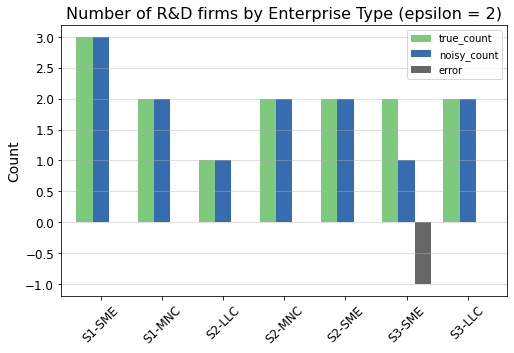

sensitivity: 1


In [49]:
# Laplacian noise
epsilon = 2 

# group by query 
count_sectors_firm_type_query = (
    QueryBuilder("sectors_analysis")
    .groupby(sectors_firm_type_keys)
    .count() 
)

# privacy budget for the query
dp_private_data = session.evaluate(
    count_sectors_firm_type_query,
    privacy_budget=PureDPBudget(epsilon), 
)

# show visualisation
visualise(dp_private_data, public_data, ["firm_type"], "count", "Count", "Number of R&D firms by Enterprise Type (epsilon = {})".format(epsilon), None, None).show()
print(f"sensitivity: {session._stability['sectors_analysis']}")

# print_laplace_confidence_interval(session._stability["sectors_analysis"], epsilon)

### 2. BERD by Enterprise Type (group by >> summation)

##### Group by: Sectors -- (SSIC), Enterprise Type ("SSE", "MNC", "LLC") -- (firm_type)
##### Summation: BERD -- (exp_total_rnd) 

  SSIC firm_type  true_sum    noisy_sum      error
0   S1       SME  6843.318  6830.889167 -12.428833
1   S1       MNC  3450.727  3438.298167 -12.428833
2   S2       LLC  3303.088  3290.659167 -12.428833
3   S2       MNC  5174.176  5161.747167 -12.428833
4   S2       SME  5935.303  5908.201167 -27.101833
5   S3       SME  5931.933  5919.504167 -12.428833
6   S3       LLC  4365.057  4352.628167 -12.428833


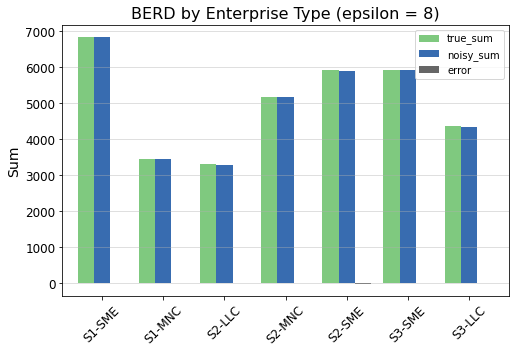

sensitivity: 1


In [42]:
# Laplacian noise
epsilon = 8
CLAMPING_BOUNDS = [0, 3500]

# group by query 
berd_sectors_firm_type_query = (
    QueryBuilder("sectors_analysis")
    .groupby(sectors_firm_type_keys)
    .sum("exp_total_rnd", low=CLAMPING_BOUNDS[0], high=CLAMPING_BOUNDS[1]) 
)

# privacy budget for the query
dp_private_data = session.evaluate(
    berd_sectors_firm_type_query,
    privacy_budget=PureDPBudget(epsilon), 
)

visualise(dp_private_data, public_data, ["firm_type"], "sum", "Sum", "BERD by Enterprise Type (epsilon = {})".format(epsilon), "exp_total_rnd", None).show()
print(f"sensitivity: {session._stability['sectors_analysis']}")

# print_laplace_confidence_interval(session._stability["sectors_analysis"]*2*4000, epsilon)

### 3. Number of Private R&D Centres by Enterprise Type (filter >> group by >> count)

##### **Filter**: Public ("Gov", "IHL", "Public RI") or Private -- (ownership_type) 
##### **Group by**: Sectors -- (SSIC), Enterprise Type ("SSE", "MNC", "LLC") -- (firm_type)
##### **Summation**: BERD -- (exp_total_rnd) 

In [43]:
sectors_firm_ownership_type_keys = KeySet.from_dict({
    "SSIC": sectors_list, 
    "firm_type": FIRM_TYPES,
    "ownership_type": OWNERSHIP_TYPES
})

sectors_firm_ownership_type_keys_filtered = sectors_firm_ownership_type_keys.filter("""
    ownership_type == 'Private'
""")

  SSIC firm_type ownership_type  true_count  noisy_count  error
0   S1       MNC        Private           2            2      0
1   S1       SME        Private           1            1      0
2   S2       MNC        Private           1            1      0
3   S2       SME        Private           1            1      0
4   S3       SME        Private           1            1      0


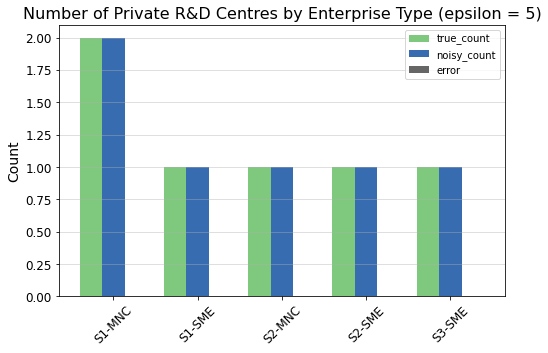

sensitivity: 1


In [51]:
# Laplacian noise
epsilon = 5 

# group by query 
count_sectors_firm_ownership_type_query = (
    QueryBuilder("sectors_analysis")
    .groupby(sectors_firm_ownership_type_keys_filtered)
    .count() 
)

# privacy budget for the query
dp_private_data = session.evaluate(
    count_sectors_firm_ownership_type_query,
    privacy_budget=PureDPBudget(epsilon), 
)

# show visualisations
visualise(dp_private_data, public_data, ["firm_type", "ownership_type"], "count", "Count", "Number of Private R&D Centres by Enterprise Type (epsilon = {})"
          .format(epsilon), None, OWNERSHIP_TYPES[-1]).show()
print(f"sensitivity: {session._stability['sectors_analysis']}")

### 4. Number of Industry Researchers by Nationality (filter >> group by >> summation)

##### **Filter**: Public ("Gov", "IHL", "Public RI") or Private -- (ownership_type) 
##### **Group by**: Sectors -- (SSIC)
##### **Summation**: Nationality ("SC", "PR", "FC") -- (no_sc_researchers, no_pr_researchers, no_fc_researchers) 

#### 4.1.  Nationality type **SC**

  SSIC ownership_type  true_sum  noisy_sum  error
0   S1        Private       718        707    -11
1   S2        Private       376        427     51
2   S3        Private       371        389     18


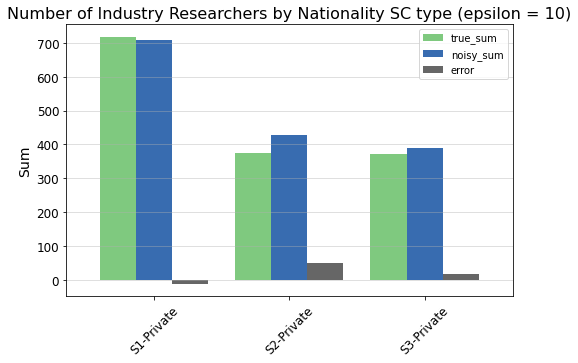

In [45]:
sectors_ownership_type_keys = KeySet.from_dict({
    "SSIC": sectors_list, 
    "ownership_type": OWNERSHIP_TYPES
})

sectors_ownership_type_keys_filtered = sectors_ownership_type_keys.filter("""
    ownership_type == 'Private'
""")

# Laplacian noise
epsilon = 10 
CLAMPING_BOUNDS = [0, 900]

# group by query 
sc_researchers_sectors_ownership_type_query = (
    QueryBuilder("sectors_analysis")
    .groupby(sectors_ownership_type_keys_filtered)
    .sum("no_sc_researchers", low=CLAMPING_BOUNDS[0], high=CLAMPING_BOUNDS[1]) 
)

# privacy budget for the query
dp_private_data = session.evaluate(
    sc_researchers_sectors_ownership_type_query,
    privacy_budget=PureDPBudget(epsilon), 
)

visualise(dp_private_data, public_data, ["ownership_type"], "sum", "Sum", 
          "Number of Industry Researchers by Nationality SC type (epsilon = {})".format(epsilon), "no_sc_researchers", "ownership_type").show()

#### 4.2.  Nationality type **PR**

  SSIC ownership_type  true_sum  noisy_sum  error
0   S1        Private       970        986     16
1   S2        Private       918        926      8
2   S3        Private       408        413      5


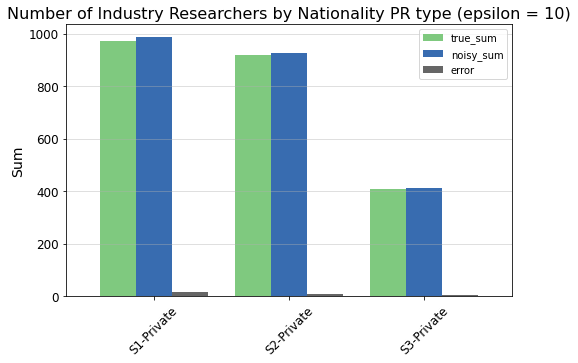

In [46]:
# Laplacian noise
epsilon = 10 
CLAMPING_BOUNDS = [0, 1000]

# group by query 
pr_researchers_sectors_ownership_type_query = (
    QueryBuilder("sectors_analysis")
    .groupby(sectors_ownership_type_keys_filtered)
    .sum("no_pr_researchers", low=CLAMPING_BOUNDS[0], high=CLAMPING_BOUNDS[1]) 
)

# privacy budget for the query
dp_private_data = session.evaluate(
    pr_researchers_sectors_ownership_type_query,
    privacy_budget=PureDPBudget(epsilon), 
)

visualise(dp_private_data, public_data, ["ownership_type"], "sum", "Sum", 
          "Number of Industry Researchers by Nationality PR type (epsilon = {})".format(epsilon), "no_pr_researchers", "ownership_type").show()

#### 4.3.  Nationality type **FC**

  SSIC ownership_type  true_sum  noisy_sum  error
0   S1        Private       879        853    -26
1   S2        Private       560        576     16
2   S3        Private       296        352     56


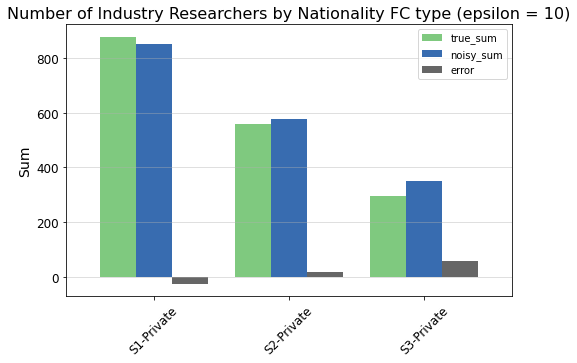

In [47]:
# Laplacian noise
epsilon = 10 
CLAMPING_BOUNDS = [0, 600]

# group by query 
fc_researchers_sectors_ownership_type_query = (
    QueryBuilder("sectors_analysis")
    .groupby(sectors_ownership_type_keys_filtered)
    .sum("no_fc_researchers", low=CLAMPING_BOUNDS[0], high=CLAMPING_BOUNDS[1]) 
)

# privacy budget for the query
dp_private_data = session.evaluate(
    fc_researchers_sectors_ownership_type_query,
    privacy_budget=PureDPBudget(epsilon), 
)

visualise(dp_private_data, public_data, ["ownership_type"], "sum", "Sum", 
          "Number of Industry Researchers by Nationality FC type (epsilon = {})".format(epsilon), "no_fc_researchers", "ownership_type").show()

In [ ]:
[1, 1, 0]